# Segmentation of Indian Traffic

In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split

In [2]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gdown

In [4]:
id = "1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ"
gdown.download(id=id, output="data.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ
To: /content/data.zip
100%|██████████| 2.34G/2.34G [00:36<00:00, 64.0MB/s]


'data.zip'

In [5]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [6]:
def return_file_names_df(root_dir):
  for dir in sorted(os.listdir(root_dir)):
    subpath = os.path.join(root_dir,dir)
    if 'images' in subpath:
      for file_dir in sorted(os.listdir(subpath)):
        sub_f = os.path.join(subpath,file_dir)
        for f in sorted(os.listdir(sub_f)):
          lst_img.append(os.path.join(sub_f,f))
    if 'mask' in subpath:
      for file_dir in sorted(os.listdir(subpath)):
        sub_f = os.path.join(subpath,file_dir)
        for f in sorted(os.listdir(sub_f)):
          lst_msk.append(os.path.join(sub_f,f))
  return lst_img, lst_msk

In [7]:
lst_msk,lst_img = [], []
root_dir = 'data'
lst_img,lst_msk = return_file_names_df(root_dir)

In [8]:
data_df = pd.DataFrame({'images': lst_img, 'json': lst_msk})
data_df.head()

images  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  
0  data/mask/201/frame0029_gtFine_polygons.json  
1  data/mask/201/frame0299_gtFine_polygons.json  
2  data/mask/201/frame0779_gtFine_polygons.json  
3  data/mask/201/frame1019_gtFine_polygons.json  
4  data/mask/201/frame1469_gtFine_polygons.json

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [9]:
import json

In [10]:
def return_unique_labels(data_df):
  labels = []
  for i in range(data_df.shape[0]):
    f = open(data_df['json'][i])
    data = json.load(f)
    for i in data["objects"]:
      labels.append(i['label'])
  labels = set(labels)
  return labels

In [11]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [12]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [13]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [14]:
def get_poly(file):
  w,h = 0, 0
  labels, vertexlist = [], []
  f = open(file)
  data = json.load(f)
  h = data['imgHeight']
  w = data['imgWidth']
  for i in data["objects"]:
    labels.append(i['label'])
    vertexlist.append([tuple(x) for x in i['polygon']])
  return w, h, labels, vertexlist

In [15]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )
grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

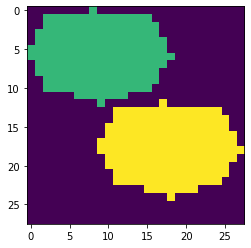

In [16]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [17]:
def compute_masks(data_df):
  os.mkdir('data/output')
  path = []
  n = []
  out_path = 'data/output'
  final_path = os.path.join(out_path, '201')
  os.mkdir(final_path)
  n.append('201')
  for i in range(data_df.shape[0]):
    f = data_df['json'][i]
    w, h, labels, vertexlist = get_poly(f)
    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    n.append(f[10:13])
    final_path = os.path.join(out_path, f[10:13])
    if (n[-2] != n[-1]):
        os.mkdir(final_path)  
    for j in range(len(vertexlist)):
      if len(vertexlist[j])>1:
        img1.polygon(vertexlist[j], fill = label_clr[labels[j]])
    img=np.array(img) 
    im = Image.fromarray(img[:,:,0])  
    im.save(os.path.join(final_path, f[14:-5]+".png"))
    path.append(os.path.join(final_path, f[14:-5]+".png"))
  return path

In [18]:
mask_path = compute_masks(data_df)

In [19]:
data_df['mask'] = mask_path

In [ ]:
data_df.head()

images  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  \
0  data/mask/201/frame0029_gtFine_polygons.json   
1  data/mask/201/frame0299_gtFine_polygons.json   
2  data/mask/201/frame0779_gtFine_polygons.json   
3  data/mask/201/frame1019_gtFine_polygons.json   
4  data/mask/201/frame1469_gtFine_polygons.json   

                                            mask  
0  data/output/201/frame0029_gtFine_polygons.png  
1  data/output/201/frame0299_gtFine_polygons.png  
2  data/output/201/frame0779_gtFine_polygons.png  
3  data/output/201/frame1019_gtFine_polygons.png  
4  data/output/201/frame1469_gtFine_polygons.png

In [ ]:
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
data_df = pd.read_csv('/content/preprocessed_data.csv')

# Task 2: Applying Unet to segment the images

In [20]:
# Data Augmentation functions.
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [21]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.7 MB/s 


In [22]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [ ]:
tf.keras.backend.set_image_data_format('channels_last')
preprocess_input = sm.get_preprocessing("vgg16")

In [ ]:
tf.keras.backend.clear_session()
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
sm.set_framework('tf.keras')

In [ ]:
def visualize(**images):
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

class Dataset:
  CLASSES = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

  def __init__(self, file_names, classes = None):

    self.ids = file_names
    self.images_fps   = [image_id for image_id in self.ids['images']]
    self.masks_fps    = [image_id for image_id in self.ids['mask']]
    self.class_values = [self.CLASSES.index(cls) for cls in classes]

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)

    mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
    mask = mask / 10


    image_masks = [(mask == v) for v in self.class_values]
    image_mask = np.stack(image_masks, axis=-1).astype('float')

    a = np.random.uniform()
    if a<0.2:
      image = aug2.augment_image(image)
      image_mask = aug2.augment_image(image_mask)
    elif a<0.4:
      image = aug3.augment_image(image)
      image_mask = aug3.augment_image(image_mask)
    elif a<0.6:
      image = aug4.augment_image(image)
      image_mask = aug4.augment_image(image_mask)
    elif a<0.8:
      image = aug5.augment_image(image)
      image_mask = image_mask
    else:
      image = aug6.augment_image(image)
      image_mask = aug6.augment_image(image_mask)
    return image, image_mask

  def __len__(self):
    return len(self.ids)


class Dataloder(tf.keras.utils.Sequence):    
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))

  def __getitem__(self, i):
    start = i * self.batch_size
    stop = (i + 1) * self.batch_size
    data = []
    for j in range(start, stop):
      data.append(self.dataset[j])

    batch = [np.stack(samples, axis=0) for samples in zip(*data)]

    return tuple(batch)

  def __len__(self):
    return len(self.indexes) // self.batch_size

  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)

In [40]:
train, val = train_test_split(data_df, test_size = 0.2)
train.shape, val.shape

((3206, 3), (802, 3))

In [ ]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
BATCH_SIZE = 16
IMAGE_SHAPE = (256, 256, 3)
n_classes = len(CLASSES)

In [ ]:
train_dataset = Dataset(train, classes=CLASSES)
val_dataset  = Dataset(val, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

(16, 256, 256, 3)


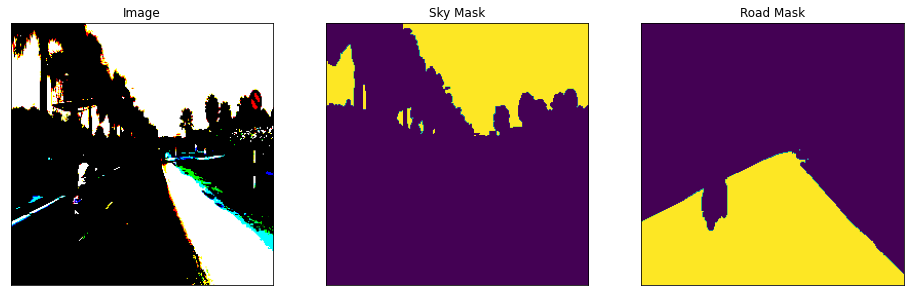

In [ ]:
img, mas = train_dataset[51]
visualize(image = img, sky_mask = mas[:, :, 16], road_mask = mas[:, :, 1])

### Task 2.2: Training Unet

In [ ]:
tf.keras.backend.clear_session()
model = Unet('vgg16', input_shape = IMAGE_SHAPE, classes = n_classes, activation = 'softmax', encoder_weights = 'imagenet')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

Dice Loss -  We can use simple crossentropy loss as we can consider this to be a multi class classification problem but the problem with using crossentropy loss is that it doesn't work well with clas imabalance and our dataset is highly imbalanced.
Hence we use dice loss, which focuses on increasing the intersection while reducing the union.

Dice loss = 1 - Dice coeff
where dice coeff = 2*TP / (TP + FP) + (TP + FN)

In [ ]:
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.dice_loss
model.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

In [ ]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath='./best_model.h5', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6),                        
]

In [ ]:
history = model.fit(train_dataloader, epochs=10,validation_data=val_dataloader, callbacks=callbacks)

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 0.8353 - iou_score: 0.3127
Epoch 1: val_iou_score improved from -inf to 0.35381, saving model to ./best_model.h5
200/200 [==============================] - 343s 2s/step - loss: 0.8353 - iou_score: 0.3127 - val_loss: 0.7926 - val_iou_score: 0.3538 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.7427 - iou_score: 0.3940
Epoch 2: val_iou_score improved from 0.35381 to 0.40306, saving model to ./best_model.h5
200/200 [==============================] - 310s 2s/step - loss: 0.7427 - iou_score: 0.3940 - val_loss: 0.7330 - val_iou_score: 0.4031 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.6902 - iou_score: 0.4341
Epoch 3: val_iou_score improved from 0.40306 to 0.44536, saving model to ./best_model.h5
200/200 [==============================] - 310s 2s/step - loss: 0.6902 - iou_score: 0.4341 - val_loss: 0.6789 - val_iou_score: 0.4454 - lr: 0.0010
Epoc

In [ ]:
model.save_weights('unet_best.pkl')

In [ ]:
model.load_weights('/content/unet_best.pkl')

In [ ]:
X_test = val.reset_index(drop=True) 

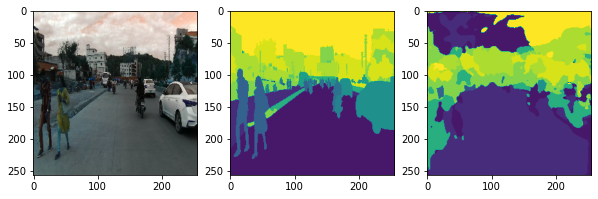

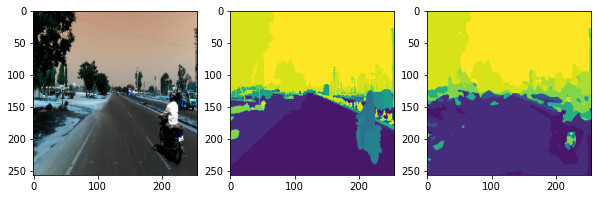

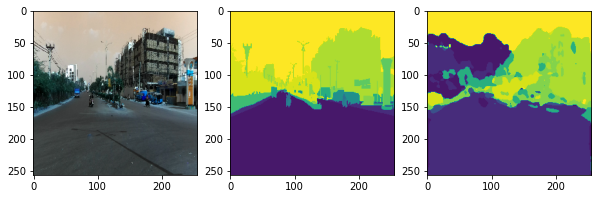

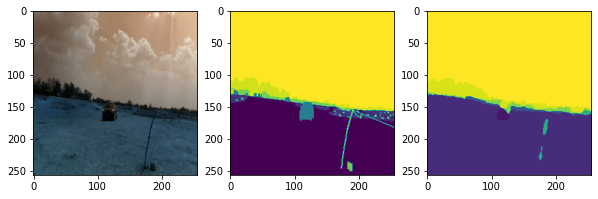

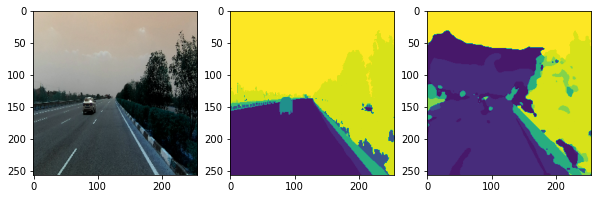

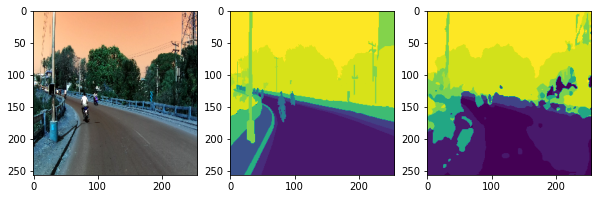

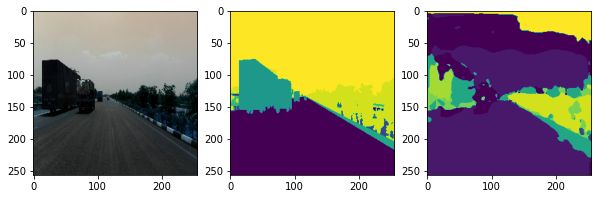

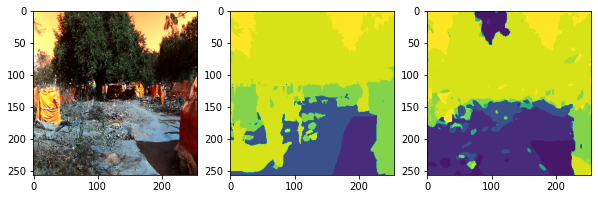

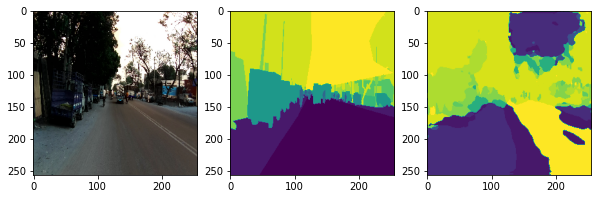

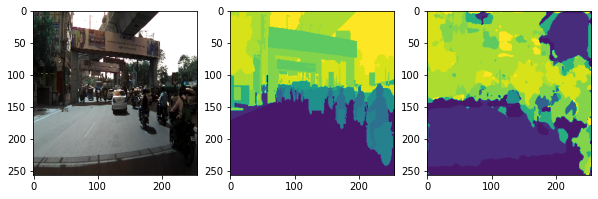

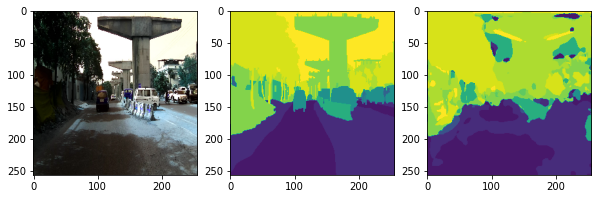

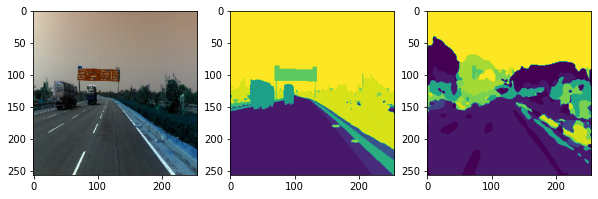

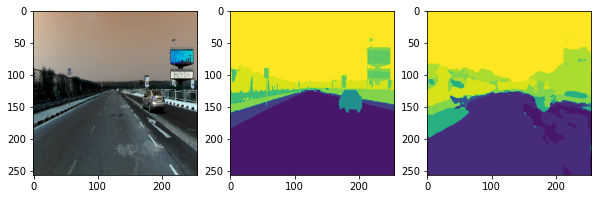

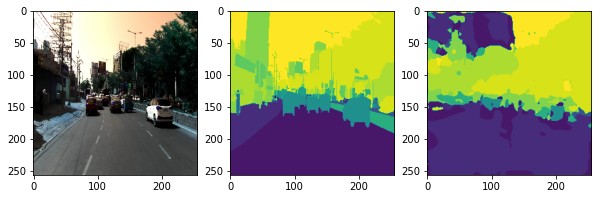

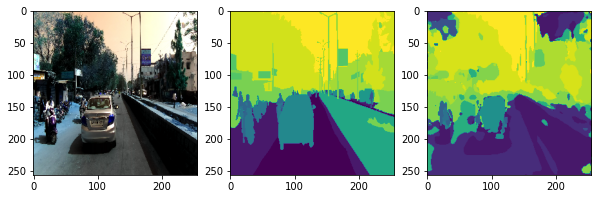

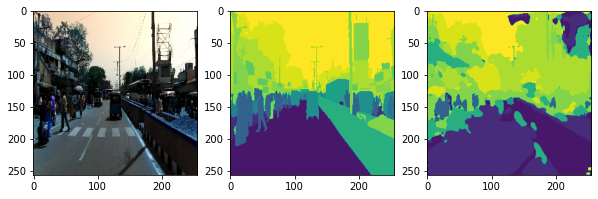

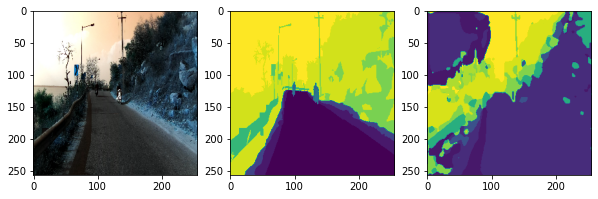

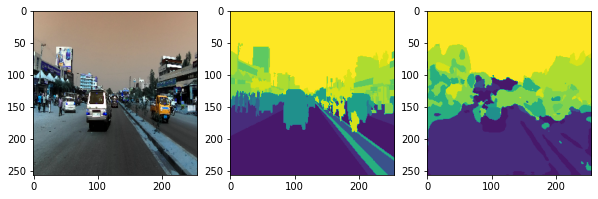

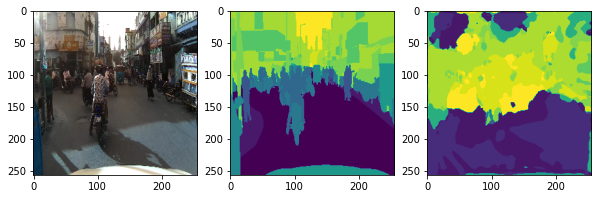

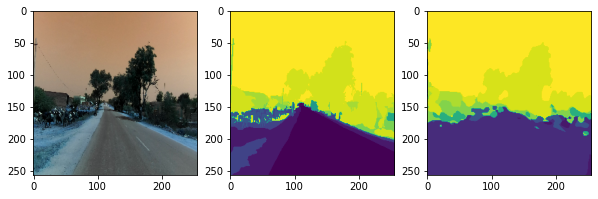

In [ ]:
a=0
for i in range(len(X_test)):
    a+=1
    image = cv2.imread(list(X_test['images'])[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST) 
    
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)

    image_mask = cv2.imread(list(X_test['mask'])[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask) 
    plt.subplot(133)
    plt.imshow(pred_mask[0])
    plt.show()
    if a==20:
      break

The val_iou_score is 0.51886 just after 10 epochs. 0.5+ IOU has been achieved

# Task 3: Training CANet

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')

In [24]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block"):
      super().__init__(name=name)
      self.F1, self.F2, self.F3 = filters
      self.kernel = kernel
      self.stride = stride
      self.conv1 =  Conv2D(self.F1,kernel_size=(1,1),strides=(self.stride,self.stride))
      self.bn1   =  BatchNormalization()
      self.bn2   =  BatchNormalization()
      self.bn3   =  BatchNormalization()
      self.bn4   =  BatchNormalization()
      self.act1  =  Activation('relu') 
      self.act2  =  Activation('relu') 
      self.act3  =  Activation('relu')  
      self.act4  =  Activation('relu')  
      self.conv2 = Conv2D(self.F2,kernel_size=(3,3),padding='same')
      self.conv3 = Conv2D(self.F3,kernel_size=(1,1))
      self.conv_parallel = Conv2D(self.F3,kernel_size=(3,3),strides=(self.stride,self.stride),padding='same')
      self.add = Add()
    def call(self, X):
      conv_1 = self.conv1(X)
      bn_1   = self.bn1(conv_1)
      act_1   = self.act1(bn_1)
      conv_2 = self.conv2(act_1)
      bn_2   = self.bn2(conv_2)
      act_2   = self.act2(bn_2)
      conv_3 = self.conv3(act_2)
      bn_3   = self.bn3(conv_3)

      conv_p = self.conv_parallel(X)
      bn_4   = self.bn4(conv_p)
      act_3   = self.act3(bn_4)

      ele_sum = self.add((act_3,bn_3))
      
      X = self.act4(ele_sum)
      return X

In [25]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=2, name="identity block"):
      super().__init__(name=name)
      self.F1, self.F2, self.F3 = filters
      self.kernel = kernel
      self.stride = stride

      self.conv1 = Conv2D(self.F1,kernel_size=(1,1),strides=(self.stride,self.stride),padding='valid')
      self.conv2 = Conv2D(self.F2,kernel_size=(3,3),padding='same')
      self.conv3 = Conv2D(self.F3,kernel_size=(1,1),padding='valid')

      self.bn1     = BatchNormalization()
      self.bn2     =  BatchNormalization()
      self.bn3     =  BatchNormalization()

      self.act1=Activation('relu') 
      self.act2=Activation('relu') 
      self.act3=Activation('relu')  

      self.add = Add()
    def call(self, X):
      conv_1 = self.conv1(X)
      bn_1   = self.bn1(conv_1)
      act_1   = self.act1(bn_1)
      conv_2 = self.conv2(act_1)
      bn_2   = self.bn2(conv_2)
      act_2   = self.act2(bn_2)
      conv_3 = self.conv3(act_2)
      bn_3   = self.bn3(conv_3)

      # parallel
      conv_p = X
      # element wise sum
      ele_sum = self.add((bn_3,conv_p))
      
      X = self.act3(ele_sum)
      return X

In [26]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
      super().__init__(name=name)
      self.global_avg_pool = GlobalAveragePooling2D()
      self.bn   = BatchNormalization()
      self.relu = tf.keras.layers.ReLU()
      self.conv = Conv2D(64,kernel_size=(1,1),padding='same')
      self.upsample = UpSampling2D(size=(32,32),interpolation='bilinear') 
        
    def call(self, X):
      global_avg = self.global_avg_pool(X)
      global_avg= tf.expand_dims(global_avg, 1)
      global_avg = tf.expand_dims(global_avg, 1)
      bn1 = self.bn(global_avg)
      relu1 = self.relu(bn1)
      conv1 = self.conv(relu1)
      X = self.upsample(conv1)    
      return X

In [27]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
      super().__init__(name=name)
      self.concat = Concatenate()
      self.avg_pool = AveragePooling2D(pool_size=(2, 2))
      self.conv1 = Conv2D(64,kernel_size=(3,3),padding='same')
      self.conv2 = Conv2D(64,kernel_size=(3,3),padding='same')
      self.conv3 = Conv2D(64,kernel_size=(1,1),padding='same')
      self.conv4= Conv2D(64,kernel_size=(1,1),padding='same')
      self.act_relu = Activation('relu')
      self.act_sigmoid = Activation('sigmoid')
      self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
      self.add = Add()
      self.multiply =Multiply()

    def call(self, X):
      INP, FLOW = X[0], X[1] 
      concat1 = self.concat([INP,FLOW])
      avg1 = self.avg_pool(concat1)
      conv_1 = self.conv1(avg1)
      conv_2 = self.conv2(conv_1)

      conv_3 = self.conv3(conv_2)
      act1   = self.act_relu(conv_3)
      conv_4 = self.conv4(act1)
      act2 = self.act_sigmoid(conv_4)

      mul1= self.multiply([conv_2,act2])
      sum2 = self.add([conv_2,mul1])
      X= self.upsample(sum2)
      return X


In [28]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
      super().__init__(name=name)
      self.conv_1 = Conv2D(32 ,kernel_size=(3,3),padding='same')
      self.global_avg_pool = GlobalAveragePooling2D()
      self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
      self.bn =BatchNormalization()
      self.act_sigmoid= Activation('sigmoid')
      self.multiply =Multiply()
      self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
      X= self.conv_1(X)
      global_avg = self.global_avg_pool(X)
      global_avg= tf.expand_dims(global_avg, 1)
      global_avg = tf.expand_dims(global_avg, 1)
      conv1= self.conv_2(global_avg)
      bn1= self.bn(conv1)
      Y = self.act_sigmoid(bn1)
      output = self.multiply([X, Y])
      FSM_Conv_T = self.upsample(output)

      return FSM_Conv_T

In [29]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
      super().__init__(name=name)
      self.conv_1  = Conv2D(32,kernel_size=(1,7),padding='same')
      self.conv_2  = Conv2D(32,kernel_size=(7,1),padding='same')
      self.conv_3  = Conv2D(32,kernel_size=(1,7),padding='same')
      self.conv_4  = Conv2D(32,kernel_size=(7,1),padding='same')
      self.conv_3  = Conv2D(32,kernel_size=(3,3),padding='same')
      self.add = Add()
      
    def call(self, X):
      conv1 = self.conv_1(X)
      conv2= self.conv_2(conv1)

      conv3 = self.conv_4(X)
      conv4 = self.conv_3(conv3)

      add1 = self.add([conv2,conv4])

      conv5 = self.conv_3(add1)

      X = self.add([conv5,add1])
      return X

In [30]:
tf.keras.backend.clear_session()

In [31]:
X_input = Input(shape=(256,256,3))
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = convolutional_block(kernel=3,filters=[4,4,8],stride= 2,name  = 'conv_block1')(X)
X_C1 = X
X = identity_block(kernel = 3,filters=[4,4,8],stride=1,name='identity_block11')(X)

X = convolutional_block(kernel=3,filters=[8,8,16],stride= 2,name  = 'conv_block2')(X)
X = identity_block(kernel = 3,filters=[8,8,16],stride=1,name='identity_block21')(X)
X = identity_block(kernel = 3,filters=[8,8,16],stride=1,name='identity_block22')(X)

X = convolutional_block(kernel=3,filters=[16,16,32],stride= 1,name  = 'conv_block3')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block31')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block32')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block33')(X)


X = convolutional_block(kernel=3,filters=[32,32,64],stride= 1,name  = 'conv_block4')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block41')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block42')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block43')(X)
X_id4 = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block44')(X)



X = global_flow(name = 'global_flow')(X_id4)
X_GF = X
X_CF1 = context_flow(name='context_flow1')([X_id4,X_GF])
X_CF2 = context_flow(name='context_flow2')([X_id4,X_CF1])
X_CF3 = context_flow(name='context_flow3')([X_id4,X_CF2])
added = add([X,X_CF1,X_CF2,X_CF3])
X_FSM = fsm(name='fsm_stage')(added)
X_agcn = agcn(name='agcn')(X_C1)
concat = Concatenate()([X_FSM,X_agcn])

Final1 = Conv2D(21, (3, 3), activation = 'relu', padding = 'same', name = 'FinalBlock1')(concat)

o_Final  = UpSampling2D((4,4), interpolation = 'bilinear')(Final1)

Final = (Activation('softmax'))(o_Final)

model = Model(inputs = X_input, outputs = Final)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 256, 256, 64  256         ['conv1[0][0]']                  
                                )                                                             

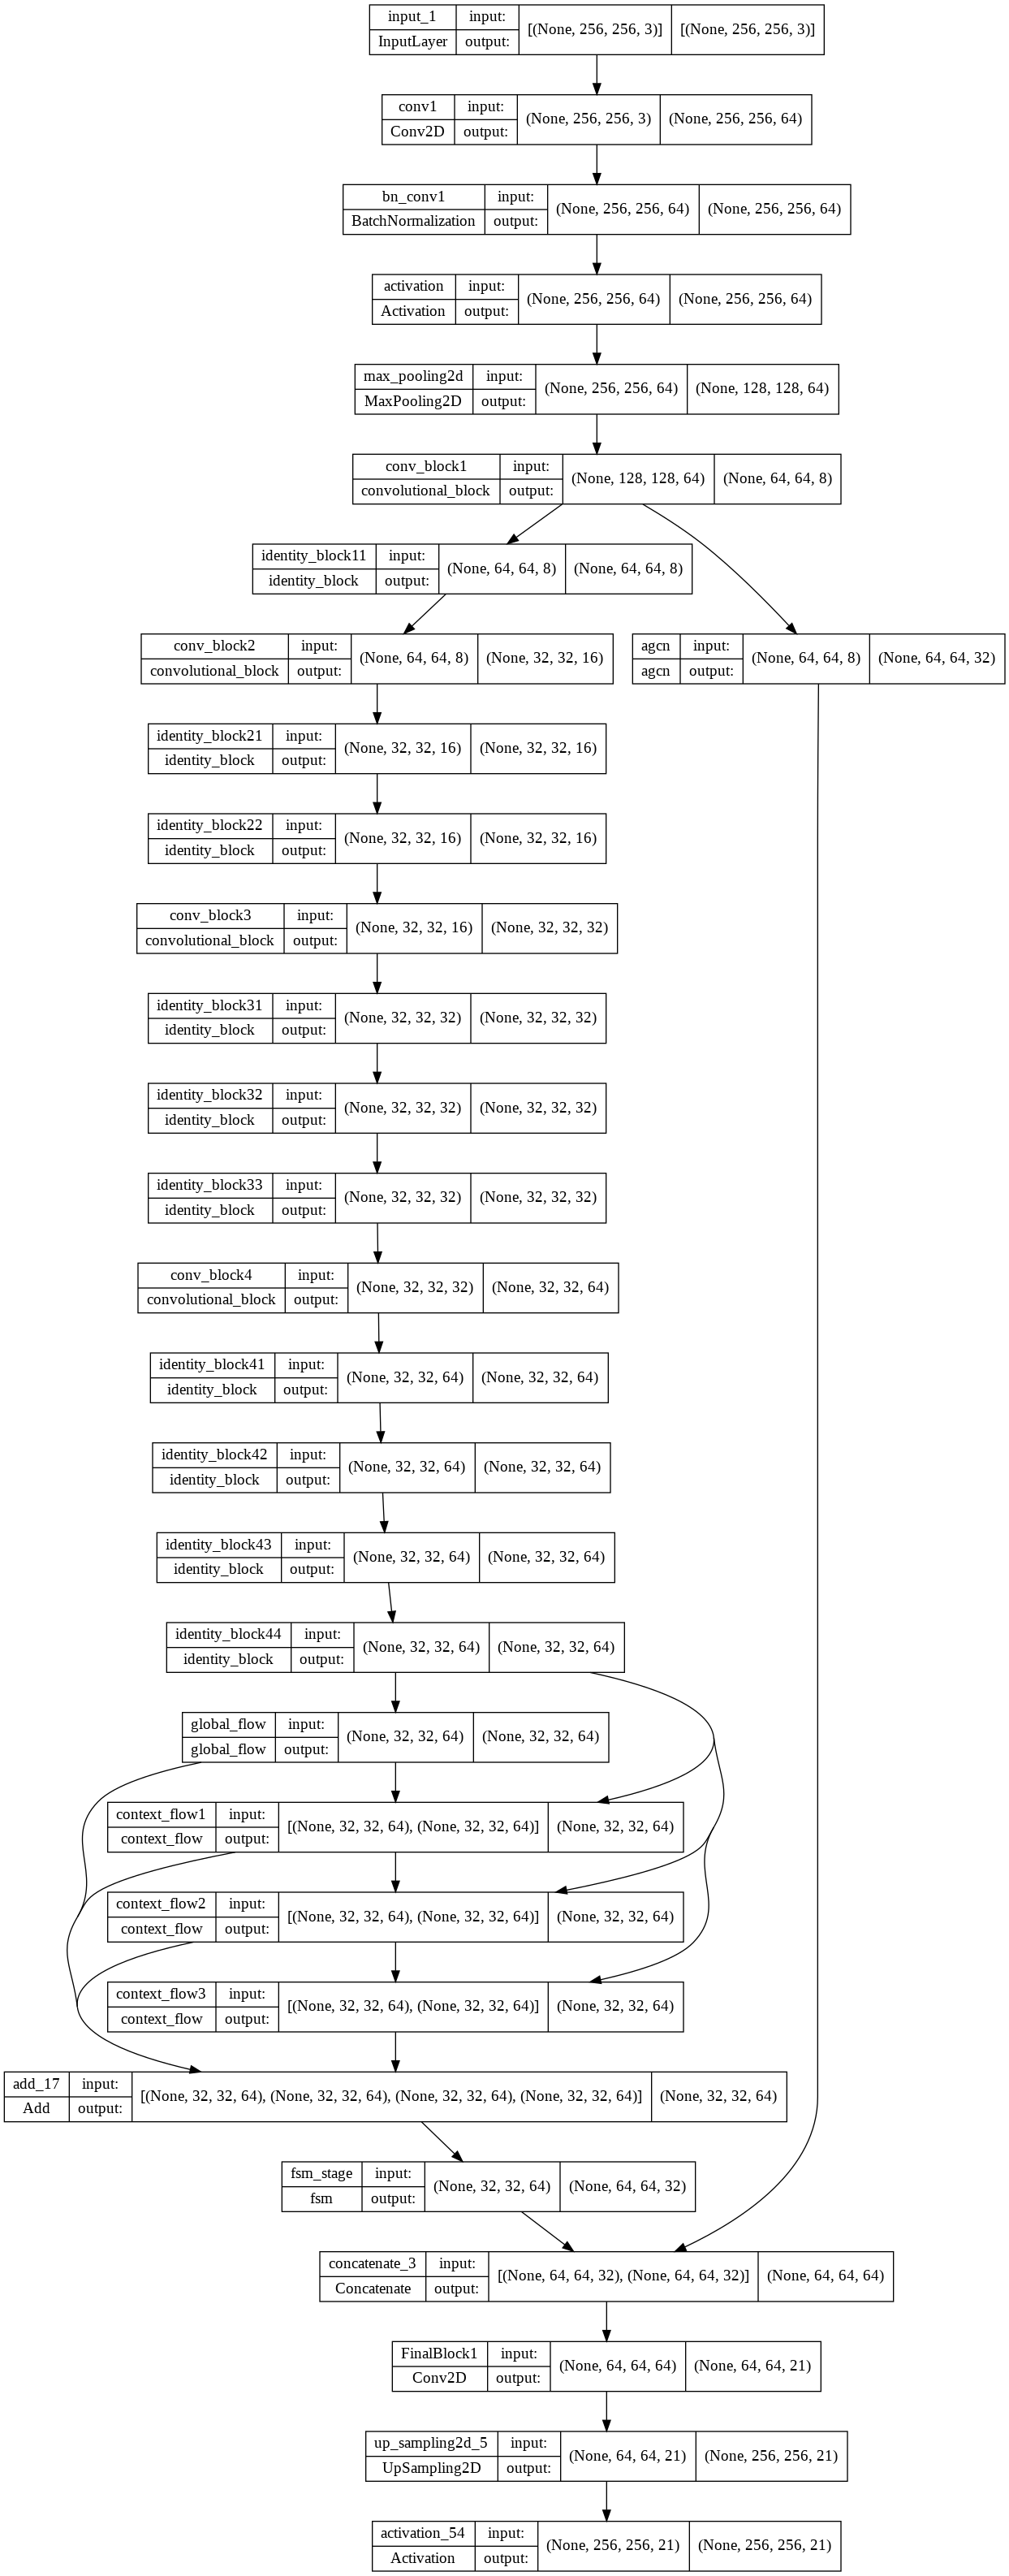

In [34]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [35]:
def visualize(**images):
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    if i==1:
      plt.imshow(image, cmap='gray', vmax=1, vmin=0)
    else:
      plt.imshow(image)
  plt.show()

class Dataset:
  def __init__(self, file_names, CLASSES):
    self.ids = file_names
    self.images_fps   = [image_id for image_id in self.ids['images']]
    self.masks_fps    = [image_id for image_id in self.ids['mask']]
    
    self.CLASSES= CLASSES
    self.class_values = CLASSES
  
  def __getitem__(self, i):
    image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(256,256),interpolation = cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
    mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask,(256,256),interpolation = cv2.INTER_NEAREST)
    image_masks = [(mask == v) for v in self.class_values]
    image_mask = np.stack(image_masks, axis=-1).astype('float')

    a = np.random.uniform()
    if a<0.2:
        image = aug2.augment_image(image)
        image_mask = aug2.augment_image(image_mask)
    elif a<0.4:
        image = aug3.augment_image(image)
        image_mask = aug3.augment_image(image_mask)
    elif a<0.6:
        image = aug4.augment_image(image)
        image_mask = aug4.augment_image(image_mask)
    elif a<0.8:
        image = aug5.augment_image(image)
        image_mask = image_mask
    else:
        image = aug6.augment_image(image)
        image_mask = aug6.augment_image(image_mask)
        
    return image, image_mask
        
  def __len__(self):
    return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))

  def __getitem__(self, i):
    start = i * self.batch_size
    stop = (i + 1) * self.batch_size
    data = []
    for j in range(start, stop):
        data.append(self.dataset[j])
      
    batch = [np.stack(samples, axis=0) for samples in zip(*data)]
    
    return tuple(batch)
  
  def __len__(self):
    return len(self.indexes) // self.batch_size
  
  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)

In [36]:
focal_loss = sm.losses.dice_loss
rms = tf.keras.optimizers.RMSprop()
model.compile(rms, focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

In [37]:
CLASSES = list(np.unique(list(label_clr.values())))

In [ ]:
train, val = train_test_split(data_df, test_size = 0.2)
train.shape, val.shape

In [41]:
train_dataset = Dataset(train, CLASSES=CLASSES)
val_dataset  = Dataset(val, CLASSES=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size = 8, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = 8, shuffle = True)


print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

checkpoint = ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min', monitor='val_iou_score')
red = ReduceLROnPlateau(monitor='val_iou_score',factor=0.2, min_lr=1e-6,patience=2)   
call = [checkpoint,red]

(8, 256, 256, 3)
(8, 256, 256, 21)


In [42]:
history = model.fit(train_dataloader, epochs=30,validation_data=val_dataloader)

Epoch 1/30
400/400 [==============================] - 271s 613ms/step - loss: 0.7709 - iou_score: 0.2193 - val_loss: 0.8024 - val_iou_score: 0.1795
Epoch 2/30
400/400 [==============================] - 245s 613ms/step - loss: 0.7505 - iou_score: 0.2253 - val_loss: 0.7391 - val_iou_score: 0.2333
Epoch 3/30
400/400 [==============================] - 242s 604ms/step - loss: 0.7246 - iou_score: 0.2474 - val_loss: 0.7565 - val_iou_score: 0.2145
Epoch 4/30
400/400 [==============================] - 239s 599ms/step - loss: 0.7237 - iou_score: 0.2500 - val_loss: 0.7140 - val_iou_score: 0.2592
Epoch 5/30
400/400 [==============================] - 274s 686ms/step - loss: 0.7228 - iou_score: 0.2516 - val_loss: 0.7571 - val_iou_score: 0.2254
Epoch 6/30
400/400 [==============================] - 238s 595ms/step - loss: 0.7254 - iou_score: 0.2518 - val_loss: 0.7721 - val_iou_score: 0.2063
Epoch 7/30
400/400 [==============================] - 240s 600ms/step - loss: 0.7473 - iou_score: 0.2323 - val_l

In [43]:
X_test  = val.reset_index(drop=True)

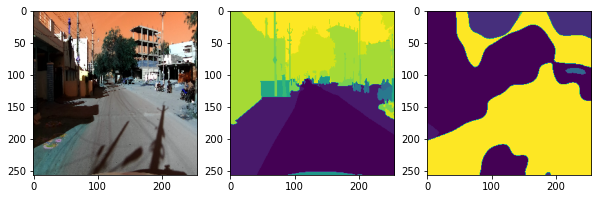

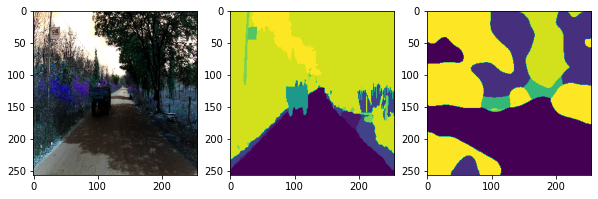

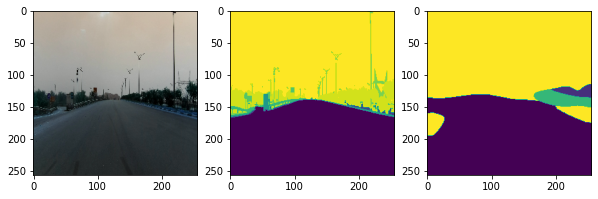

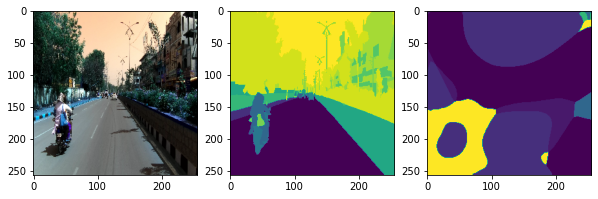

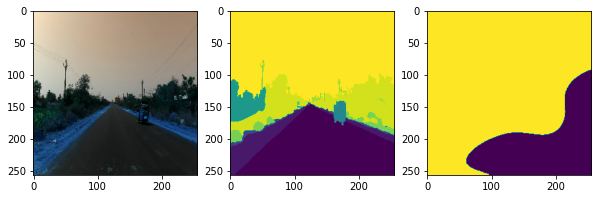

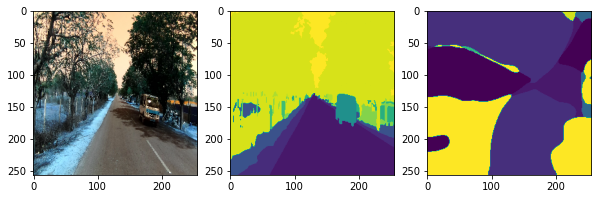

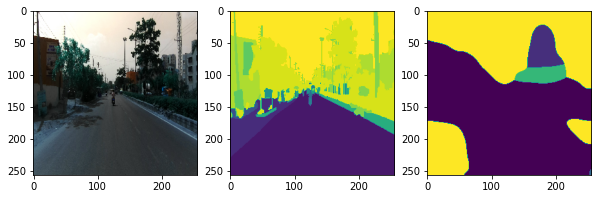

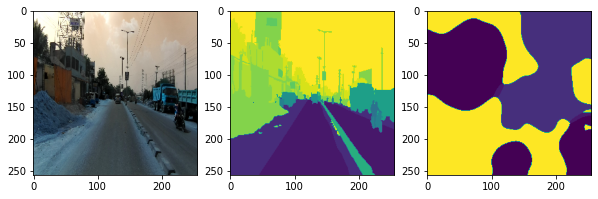

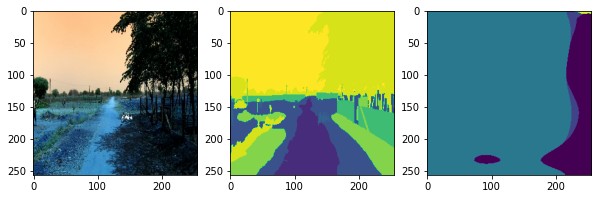

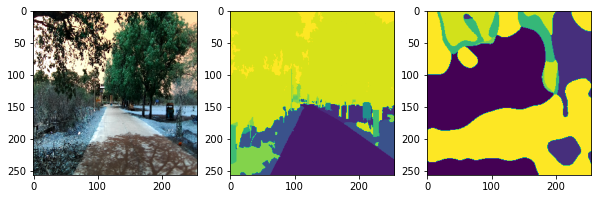

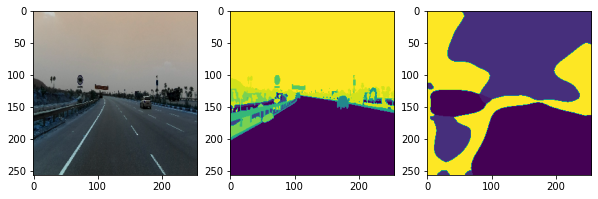

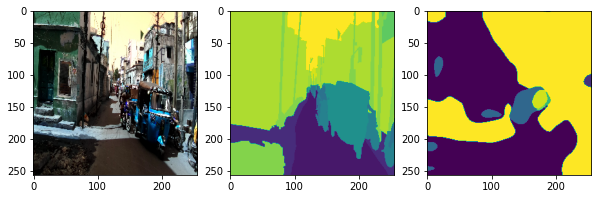

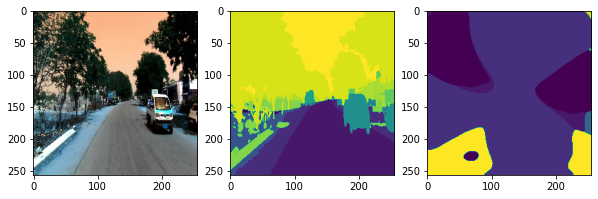

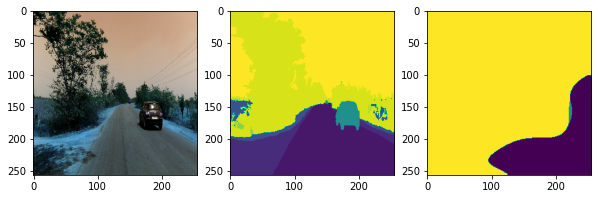

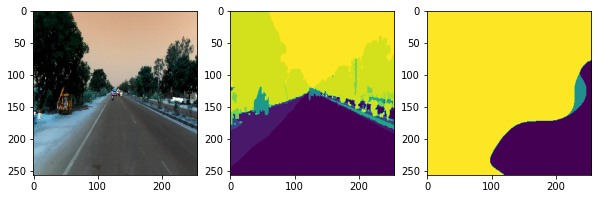

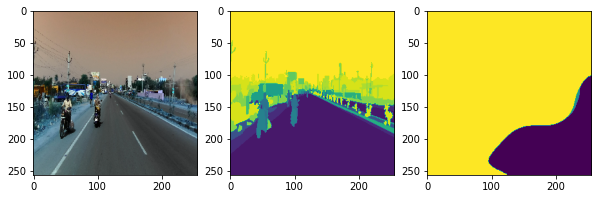

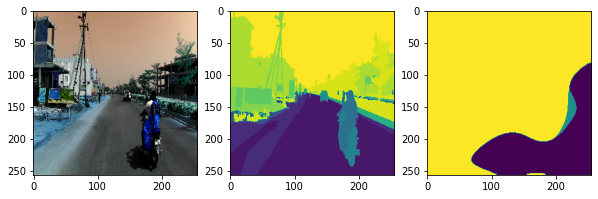

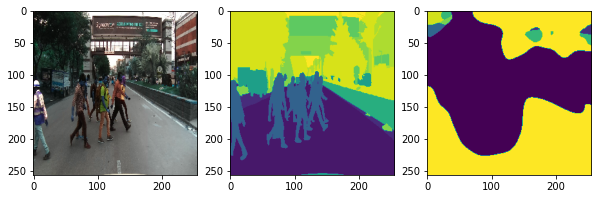

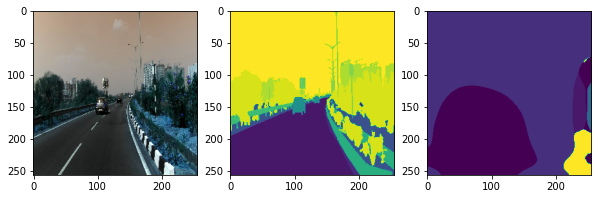

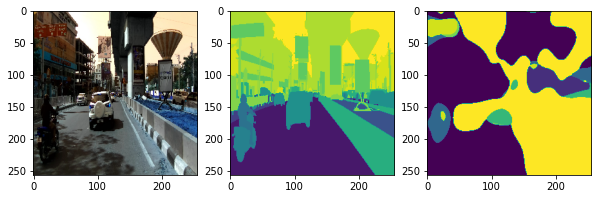

In [44]:
a=0
for i in range(len(X_test)):
  a+=1
  image = cv2.imread(list(X_test['images'])[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST) 
  
  pred_mask  = model.predict(image[np.newaxis,:,:,:])
  pred_mask = tf.argmax(pred_mask, axis=-1)
  
  image_mask = cv2.imread(list(X_test['mask'])[i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)  

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.subplot(132)
  plt.imshow(image_mask) 
  plt.subplot(133)
  plt.imshow(pred_mask[0])
  plt.show()
  if a==20:
    break